In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [3]:
from pbcpy.local_functionals_utils import *

In [4]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [5]:
from pbcpy.semilocal_xc import PBE, LDA, XC

In [6]:
from pbcpy.local_pseudopotential import NuclearElectron

In [7]:
from pbcpy.hartree import HartreeFunctional

# read electron density from file

In [8]:
mol = PP(filepp='Al_fde_rho.pp').read()
rho_of_r = mol.field

# $E_{eN}$ and $v_{eN}$ but not yet $E_{NN}$

In [9]:
NuclearElectron = NuclearElectron(mol.ions,rho_of_r,["./Al_lda.oe01.recpot","./Al_lda.oe01.recpot"])

Recpot pseudopotential ./Al_lda.oe01.recpot loaded
Recpot pseudopotential ./Al_lda.oe01.recpot loaded


In [10]:
NuclearElectron.name

'Local Pseudopotential'

# $E_H$ and $v_{H}$

In [11]:
Hartree = HartreeFunctional(rho_of_r)

In [12]:
Hartree.name

'Hartree'

# $E_{xc}$ and $v_{xc}$

In [13]:
ExchangeCorrelation_LDA = LDA(rho_of_r,polarization='unpolarized')

In [14]:
ExchangeCorrelation_PBE = PBE(rho_of_r,polarization='unpolarized')

# Check against PROFESS

In [15]:
ion_profess = PP("./pot_pp/pot_ion.pp").read()
xc_profess = PP("./pot_pp/pot_XC.pp").read()
xc_pbe_profess = PP("./pot_pp/pot_XC_PBE.pp").read()
hart_profess = PP("./pot_pp/pot_H.pp").read()

# local part of PP

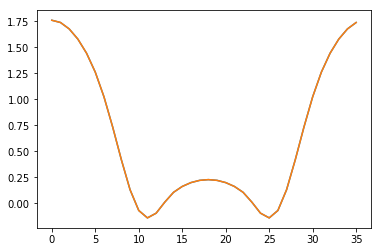

In [16]:
plt.plot(ion_profess.field[:,0,0,0])
plt.plot(NuclearElectron.potential[:,0,0,0])
plt.show()

# XC potential

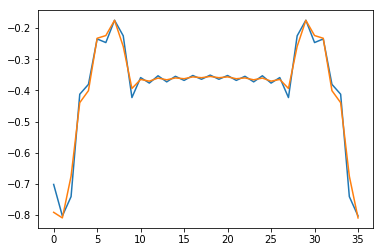

In [17]:
#plt.plot(xc_profess.field[:,0,0,0])
plt.plot(xc_pbe_profess.field[:,0,0,0])
#plt.plot(ExchangeCorrelation_LDA.potential[:,0,0,0])
plt.plot(ExchangeCorrelation_PBE.potential[:,0,0,0])
plt.show()

# Hartree potential

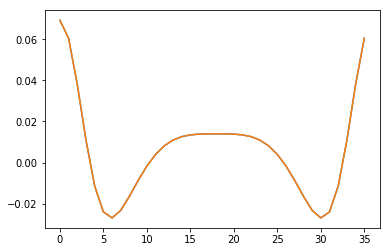

In [18]:
plt.plot(hart_profess.field[:,0,0,0])
plt.plot(Hartree.potential[:,0,0,0])
plt.show()

# Check semilocal TF_plus_vW

In [19]:
blafunc = x_TF_y_vW(rho_of_r,x=1,y=0.1,Sigma=0.05)

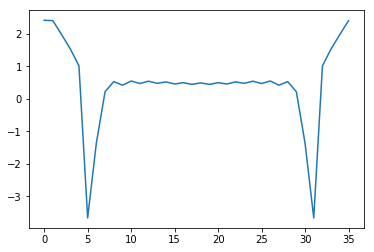

In [20]:
plt.plot(blafunc.potential[:,0,0,0])
plt.show()

In [21]:
v_eff = -ExchangeCorrelation_LDA.potential - Hartree.potential + NuclearElectron.potential

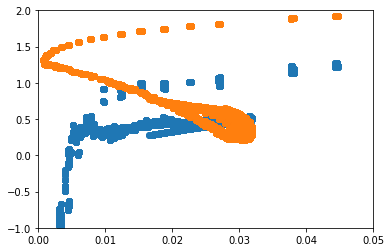

In [22]:
plt.scatter(rho_of_r.reshape(rho_of_r.grid.nnr),blafunc.potential.reshape(rho_of_r.grid.nnr))
plt.scatter(rho_of_r.reshape(rho_of_r.grid.nnr),v_eff.reshape(rho_of_r.grid.nnr))
plt.xlim([0.0,0.05])
plt.ylim([-1,2])
plt.show()